<a href="https://colab.research.google.com/github/amradadic/SoftwareProject-SarcasamDetection/blob/SPIRS/BERT_user_embedding_attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT user embedding attribution** distribution

**Change all paths before executing notebook**

In [ ]:
import torch
torch.cuda.empty_cache()

!%%cache
!pip install rpy2

!%%cache
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
from sklearn import metrics as m

!%%cache
!pip3 install pickle5
import pickle5 as pickle

/bin/bash: line 0: fg: no job control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: line 0: fg: no job control
Mounted at /content/drive
/bin/bash: line 0: fg: no job control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 26.3 MB/s 


## **Data loading and preprocessing**

In [ ]:
x_train = pd.read_csv('drive/MyDrive/SP/Data/x_train.csv') #when not on colab change path to 'split/x_train.csv'
y_train = pd.read_csv('drive/MyDrive/SP/Data/y_train.csv') #'split/y_train.csv'

x_test = pd.read_csv('drive/MyDrive/SP/Data/x_test.csv') #'split/x_test.csv'
y_test = pd.read_csv('drive/MyDrive/SP/Data/y_test.csv') #'split/y_test.csv'

x_val = pd.read_csv('drive/MyDrive/SP/Data/x_val.csv') #'split/x_val.csv'
y_val = pd.read_csv('drive/MyDrive/SP/Data/y_val.csv') #'split/y_val.csv'

df_train = pd.concat([x_train, y_train], axis=1, join='inner')
df_test = pd.concat([x_test, y_test], axis=1, join='inner')
df_val = pd.concat([x_val, y_val], axis=1, join='inner')

df_train.shape, df_val.shape, df_test.shape


((16308, 17), (2878, 17), (4797, 17))

In [ ]:
def modify_df(df):
  df = df.dropna(subset = ['sar_text'])
  df = df.reset_index(drop=True)
  #add user_id
  for i in range(len(df['sar_user'])):
    user = df['sar_user'][i].split('|')
    df['sar_user'][i] = int(user[-1])

  cols = ['obl_text', 'eli_text', 'cue_text', 'obl_id',	'eli_id',	'perspective', 'cue_user', 'obl_user',	'eli_user', 'idx',	'pattern',	'person',	'cue_id'	]
  df.drop(cols, axis = 1, inplace = True)
  df.rename(columns = {'sar_user':'user_id'}, inplace = True)
  print(type(df))
  return df

In [ ]:
df_train = modify_df(df_train)
df_test = modify_df(df_test)
df_val = modify_df(df_val)
df_val.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,sar_id,sar_text,user_id,label
0,1.184318e+18,bye damn good job. read mlb better anybody. wi...,1066920507122098176,1
1,1.195560e+18,number ring? oomfs heard shit ring????,3105498811,0
2,1.196460e+18,thanks lot,735016814464339968,1
3,1.197357e+18,know? joe biden write violence women act?,1013124578498039810,1
4,1.199070e+18,lindsey graham looks sick. lies hes required t...,551507199,0


In [ ]:
data = pd.concat([df_train, df_test, df_val], ignore_index=True)
user_id_ordered = data['user_id']

In [ ]:
data.shape

(23633, 4)

## **User embeddings loading and modifying**

In [ ]:
with open('drive/MyDrive/user_attribution/user_attribution_distribution.pickle', 'rb') as handle:
  dict_user_embeddings = pickle.load(handle)

In [ ]:
len(dict_user_embeddings[list(dict_user_embeddings.keys())[0]])

15329

In [ ]:
user_embeddings_ordered = []
users_without_embeddings = []
for i in range(len(user_id_ordered)):
  if user_id_ordered[i] in dict_user_embeddings:
    user_embeddings_ordered.append(dict_user_embeddings[user_id_ordered[i]])
  else:
    users_without_embeddings.append(user_id_ordered[i])
#user_embeddings_ordered


In [ ]:
#DROPING TWEETS THAT HAVE USER IDS WHICH ARE NOT IN USER EMBEDDINGS
df_train.drop(df_train[df_train["user_id"].isin(users_without_embeddings)].index, inplace = True)
df_test.drop(df_test[df_test["user_id"].isin(users_without_embeddings)].index, inplace = True)
df_val.drop(df_val[df_val["user_id"].isin(users_without_embeddings)].index, inplace = True)

## **Setup & Config**

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.4 MB 15.5 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.20.1



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Fixing max length and user_dim

In [ ]:
user_dim = len(dict_user_embeddings[list(dict_user_embeddings.keys())[0]])
MAX_LEN = 512

##**Data Loader**

In [ ]:
class SarcasticTweetsDataset(Dataset):

  def __init__(self, sar_texts, user_ids, targets, tokenizer, max_len):
    self.sar_texts = sar_texts
    self.user_ids = user_ids
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sar_texts)
  
  def __getitem__(self, item):
    sar_text = str(self.sar_texts[item])
    user_id = self.user_ids[item]
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sar_text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'sar_text': sar_text,
      'user_id': user_id,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SarcasticTweetsDataset(
    sar_texts=df.sar_text.to_numpy(),
    user_ids = df.user_id.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

dict_keys(['sar_text', 'user_id', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
print(data['user_id'].shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])
torch.Size([32])


## **Classifier**

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [ ]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes, users_dim = user_dim): 
    super(SarcasmClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.7)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    if users_dim != None:
      self.scale_down = nn.Linear(self.bert.config.hidden_size, users_dim)
      self.out = nn.Linear(2 * users_dim, n_classes)
      #self.out = nn.Linear(users_dim, n_classes)
    else:
      self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, user_embeddings):
    ob = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(ob.pooler_output)

    if user_embeddings != None:
      pooled_output = self.scale_down(output)
      concat = torch.cat((pooled_output, user_embeddings), dim=1)
      logits = self.out(concat.float())
    else:
      logits = self.out(output)

    return logits

    

In [ ]:
class_names = ['positive', 'negative']

In [ ]:
model = SarcasmClassifier(len(class_names), user_dim)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
user_ids = data['user_id'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 512])
torch.Size([32, 512])


## **Training**

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    user_ids = d['user_id'].to(device)
    user_embeddings = [] 
    for i in range(len(input_ids)):
      if user_ids[i].item() in dict_user_embeddings:
        user_embeddings.append(dict_user_embeddings[user_ids[i].item()])


    user_embeddings = torch.tensor(user_embeddings).to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      user_embeddings = user_embeddings
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      user_ids = d['user_id'].to(device) 
      user_embeddings = [] 
      for i in range(len(user_ids)):
        if user_ids[i].item() in dict_user_embeddings:
          user_embeddings.append(dict_user_embeddings[user_ids[i].item()])
        
      user_embeddings = torch.tensor(user_embeddings).to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        user_embeddings = user_embeddings
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
df_val['label'].to_numpy()
import numpy as np
unique, counts = np.unique(df_train['label'].to_numpy(), return_counts=True)

dict(zip(unique, counts))

{0: 7993, 1: 7856}

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

Train loss 0.6500051303976967 accuracy 0.6266641428481292


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.6093586097386751 accuracy 0.6690518783542039

Epoch 2/2
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Train loss 0.5357071084961775 accuracy 0.7394157360085809


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

Val   loss 0.6248194808987054 accuracy 0.6726296958855098

CPU times: user 11min 19s, sys: 9.45 s, total: 11min 28s
Wall time: 11min 42s


## **Evaluation**

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

0.668806161745828

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sar_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["sar_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      user_ids = d['user_id'].to(device) 
      user_embeddings = [] 
      for i in range(len(input_ids)):
        if user_ids[i].item() in dict_user_embeddings:
          user_embeddings.append(dict_user_embeddings[user_ids[i].item()])

      user_embeddings = torch.tensor(user_embeddings).to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        user_embeddings = user_embeddings 
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sar_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sar_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.70      0.63      0.67      2428
    negative       0.64      0.71      0.67      2246

    accuracy                           0.67      4674
   macro avg       0.67      0.67      0.67      4674
weighted avg       0.67      0.67      0.67      4674



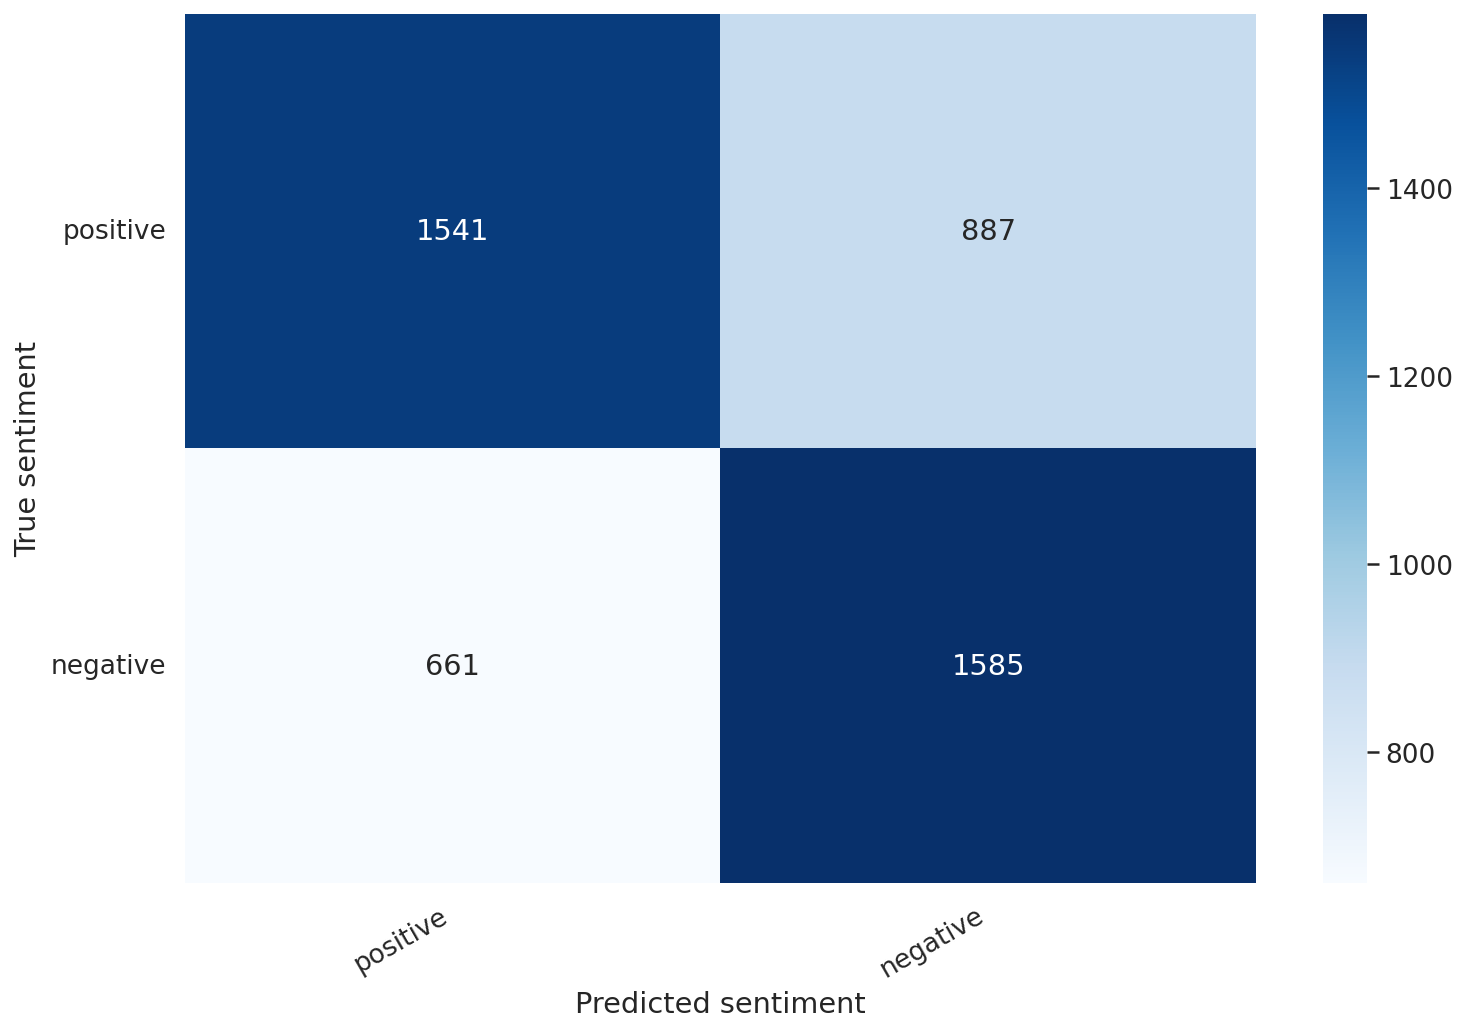

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## **Saving json file and model**



In [ ]:
from metrics import metrics, json_metrics #when not in colab from utils import metrics

sar_ids = df_test['sar_id']
metrics = metrics(y_test, y_pred, ['1','0'])
df= pd.DataFrame({'sar_id': sar_ids, 'label': y_test, 'prediction': y_pred})
json_metrics("/content/drive/MyDrive/SP/JSON/bert_userembeddings3_distribution.json", "sentence BERT", "User_Embedings3_Distribution",metrics, df)

In [ ]:
torch.save(model, 'drive/MyDrive/SP/Models/Bert_Model_UserEmbeddings3_Distribution')